# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

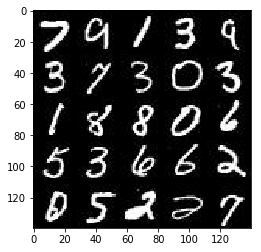

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

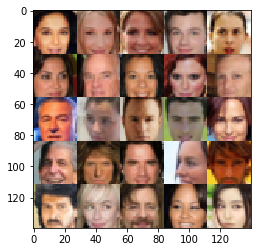

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function

    # Define placeholder for image details
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_image')
    
    # Define placeholder for image z dim
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')

    # Define placeholder for learning rate
    input_learning_rate = tf.placeholder(tf.float32, (None), name='input_learning_rate')

    return input_real, input_z, input_learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    
    # Image input is 28x28x(1 or 3)
    width = 28
    # Starting filter depth is hard set to 32
    depth = 32
    
    # Define alpha for relu
    alpha = 0.2
    
    # Reuse variables 
    with tf.variable_scope('discriminator', reuse=reuse):
        #First Fully connected layer // Add kernel initializer
        layer1 = tf.layers.conv2d(
            images, 
            depth, 
            5, 
            strides=2, 
            padding='same',
            kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=False)
        )
        # Define leaky relu (don't normalize)
        relu1 = tf.maximum(alpha*layer1, layer1)
        # Data is 14x14x32
        
        # Double the filter depth
        depth = int(2*depth)
        
        # Define second conv layer in stack // Add kernel initializer
        layer2 = tf.layers.conv2d(
            relu1, 
            depth, 
            5, 
            strides=2, 
            padding='same',
            kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=False)
        )
        # Normalize layer
        layer2 = tf.layers.batch_normalization(layer2, training=True)
        # Define leaky relu (don't normalize)
        relu2 = tf.maximum(alpha*layer2, layer2)
        # Data is 7x7x64     
        
        # Double the filter depth
        depth = int(2*depth)
        
        # Define third conv layer in stack // Add kernel initializer
        layer3 = tf.layers.conv2d(
            relu2, 
            depth, 
            5, 
            strides=2, 
            padding='same',
            kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=False)
        )
        # Normalize layer
        layer3 = tf.layers.batch_normalization(layer3, training=True)
        # Define leaky relu (don't normalize)
        relu3 = tf.maximum(alpha*layer3, layer3)
        # Data is 4x4x128      
        
        # Double the filter depth
        depth = int(2*depth)
        
        # Define fourth conv layer in stack // Add kernel initializer
        layer4 = tf.layers.conv2d(
            relu3, 
            depth, 
            5, 
            strides=2, 
            padding='same',
            kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=False)
        )
        # Normalize layer
        layer4 = tf.layers.batch_normalization(layer4, training=True)
        # Define leaky relu (don't normalize)
        relu4 = tf.maximum(alpha*layer4, layer4)
        # Data is 2x2x256
        
        # Flatten relu
        flat = tf.reshape(relu4, (-1,2*2*depth))
        # Calculate logits and output // Add kernel initializer
        logits = tf.layers.dense(
            flat,
            1,
            kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=False)
        )
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    # Incoming filter depth 
    depth = 512
    
    # Define alpha for relu
    alpha = 0.2
    
    with tf.variable_scope('generator', reuse = not is_train):
        # Data in is 4x4x128      

        # First fully connected layer
        layer1 = tf.layers.dense(z, 4*4*depth)
        # Reshape the layer for first conv layer in stack
        layer1 = tf.reshape(layer1, (-1,4,4,depth))
        # Normalize layer
        layer1 = tf.layers.batch_normalization(layer1, training=is_train)
        # Define leaky relu
        layer1 = tf.maximum(alpha*layer1, layer1)
        # Data is 4x4x512
        
        # Quarter the filter depth
        depth = int(depth/4)

        # Define second conv layer in stack // Add kernel initializer
        layer2 = tf.layers.conv2d_transpose(
            layer1, 
            depth, 
            4, 
            strides=1, 
            padding='valid',
            kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=False)

        )
        # Normalize layer
        layer2 = tf.layers.batch_normalization(layer2, training=is_train)
        # Define leaky relu
        layer2 = tf.maximum(alpha*layer2, layer2)
        # Data is 8x8x128
        
        # Halve the filter depth
        depth = int(depth/2)
        
        # Define third conv layer in stack // Add kernel initializer
        layer3 = tf.layers.conv2d_transpose(
            layer2, 
            depth, 
            5, 
            strides=2, 
            padding='same',
            kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=False)

        )
        # Normalize layer
        layer3 = tf.layers.batch_normalization(layer3, training=is_train)
        # Define leaky relu
        layer3 = tf.maximum(alpha*layer3, layer3)
        # Data is 16x16x64
        
        # Halve the filter depth
        depth = int(depth/2)
        
        # Define third conv layer in stack // Add kernel initializer
        layer4 = tf.layers.conv2d_transpose(
            layer3, 
            depth, 
            5, 
            strides=2, 
            padding='same',
            kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=False)
        )
        # Normalize layer
        layer4 = tf.layers.batch_normalization(layer4, training=is_train)
        # Define leaky relu
        layer4 = tf.maximum(alpha*layer4, layer4)
        # Data is 32x32x32
        
        # Output layer // Add kernel initializer
        logits = tf.layers.conv2d_transpose(
            layer4, 
            out_channel_dim, 
            3, 
            strides=1, 
            padding='same',
            kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=False)
        )
        # Data is  32x32x3

        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    # Define loss smoothing
    smooth = 0.1
    
    # Create generator model
    g_model = generator(input_z, out_channel_dim)
    # Create discriminator models
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    # Calc d loss - include smoothing in real
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_logits_real)*smooth))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_logits_fake)))
    
    # Sum real and fake d loss
    d_loss = d_loss_real + d_loss_fake
    
    # Calc g loss
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_logits_fake)))

    return d_loss, g_loss



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    gen_updates = [op for op in update_ops if op.name.startswith('generator')]
    
    with tf.control_dependencies(gen_updates):

        # Optimize
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

        return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    # Split out the shape data
    _, img_width, img_height, img_channels = data_shape
    
    # Create the inputs - data shape is number of images, image_width, image_height, image_channels
    in_real, in_z, in_lr = model_inputs(img_width, img_height, img_channels, z_dim)

    # Set up losses
    d_loss, g_loss = model_loss(in_real, in_z, img_channels)
            
    # Set up optimizers
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    # Keep track of steps
    steps = 0
    # Define how often to print and show output
    print_output = 10
    show_output = 100
    
    # Create saver object
    saver = tf.train.Saver()
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                
                # Increment steps
                steps += 1
                
                # Double image values to -1,1
                batch_images *= 2
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers for session
                _ = sess.run(d_opt, feed_dict={in_real: batch_images, in_z: batch_z, in_lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={in_z: batch_z, in_lr: learning_rate})
                
                # Print loss output every x steps
                if steps % print_output == 0:
                    # Calculate loss per session
                    d_loss_train = d_loss.eval({
                        in_z: batch_z,
                        in_real: batch_images
                    })
                    g_loss_train = g_loss.eval({
                        in_z: batch_z
                    })
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(d_loss_train),
                          "Generator Loss: {:.4f}".format(g_loss_train))
                
                # Show generator output every x steps
                if steps % show_output == 0:
                    show_generator_output(sess, 25, in_z, img_channels, data_image_mode)
                    
        saver.save(sess, './train.ckpt')



### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.4691... Generator Loss: 6.0301
Epoch 1/2... Discriminator Loss: 0.3491... Generator Loss: 4.0031
Epoch 1/2... Discriminator Loss: 0.3674... Generator Loss: 5.2081
Epoch 1/2... Discriminator Loss: 0.3793... Generator Loss: 3.2311
Epoch 1/2... Discriminator Loss: 0.3452... Generator Loss: 4.7383
Epoch 1/2... Discriminator Loss: 0.3600... Generator Loss: 4.4209
Epoch 1/2... Discriminator Loss: 0.3766... Generator Loss: 3.1957
Epoch 1/2... Discriminator Loss: 0.3789... Generator Loss: 3.5536
Epoch 1/2... Discriminator Loss: 0.3402... Generator Loss: 4.6053
Epoch 1/2... Discriminator Loss: 0.3757... Generator Loss: 3.1271


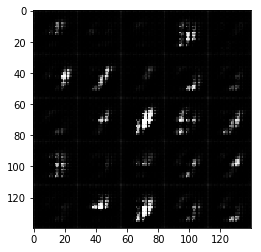

Epoch 1/2... Discriminator Loss: 0.3714... Generator Loss: 3.3081
Epoch 1/2... Discriminator Loss: 0.4171... Generator Loss: 2.5094
Epoch 1/2... Discriminator Loss: 0.3587... Generator Loss: 3.6217
Epoch 1/2... Discriminator Loss: 0.3832... Generator Loss: 2.9680
Epoch 1/2... Discriminator Loss: 0.3980... Generator Loss: 2.8825
Epoch 1/2... Discriminator Loss: 0.3673... Generator Loss: 3.8011
Epoch 1/2... Discriminator Loss: 0.4362... Generator Loss: 4.0363
Epoch 1/2... Discriminator Loss: 0.4026... Generator Loss: 2.7381
Epoch 1/2... Discriminator Loss: 0.3913... Generator Loss: 3.1423
Epoch 1/2... Discriminator Loss: 0.3883... Generator Loss: 3.4409


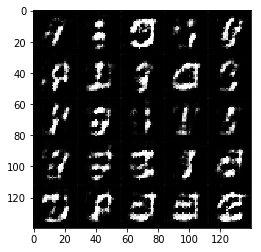

Epoch 1/2... Discriminator Loss: 0.3846... Generator Loss: 2.9968
Epoch 1/2... Discriminator Loss: 0.3770... Generator Loss: 3.6127
Epoch 1/2... Discriminator Loss: 0.3869... Generator Loss: 3.0439
Epoch 1/2... Discriminator Loss: 0.3797... Generator Loss: 3.2818
Epoch 1/2... Discriminator Loss: 0.3799... Generator Loss: 3.1052
Epoch 1/2... Discriminator Loss: 0.3735... Generator Loss: 3.5681
Epoch 1/2... Discriminator Loss: 0.4144... Generator Loss: 2.7155
Epoch 1/2... Discriminator Loss: 0.3784... Generator Loss: 3.2907
Epoch 1/2... Discriminator Loss: 0.4093... Generator Loss: 3.6217
Epoch 1/2... Discriminator Loss: 0.3757... Generator Loss: 3.3328


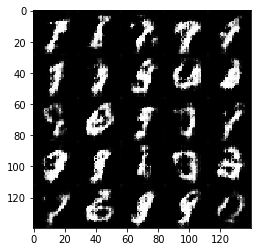

Epoch 1/2... Discriminator Loss: 0.3928... Generator Loss: 2.8414
Epoch 1/2... Discriminator Loss: 0.3944... Generator Loss: 3.0989
Epoch 1/2... Discriminator Loss: 0.3896... Generator Loss: 3.4305
Epoch 1/2... Discriminator Loss: 0.4027... Generator Loss: 2.7443
Epoch 1/2... Discriminator Loss: 0.4273... Generator Loss: 2.3966
Epoch 1/2... Discriminator Loss: 0.3838... Generator Loss: 3.0663
Epoch 1/2... Discriminator Loss: 0.3862... Generator Loss: 3.2418
Epoch 1/2... Discriminator Loss: 0.3844... Generator Loss: 3.1570
Epoch 1/2... Discriminator Loss: 0.4004... Generator Loss: 3.2035
Epoch 1/2... Discriminator Loss: 0.4152... Generator Loss: 2.5626


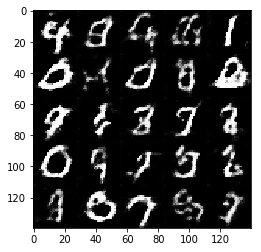

Epoch 1/2... Discriminator Loss: 0.3950... Generator Loss: 2.8912
Epoch 1/2... Discriminator Loss: 0.3888... Generator Loss: 3.0804
Epoch 1/2... Discriminator Loss: 0.3982... Generator Loss: 2.9039
Epoch 1/2... Discriminator Loss: 0.3883... Generator Loss: 3.4441
Epoch 1/2... Discriminator Loss: 0.3901... Generator Loss: 2.9813
Epoch 1/2... Discriminator Loss: 0.3850... Generator Loss: 3.3610
Epoch 1/2... Discriminator Loss: 0.3882... Generator Loss: 3.4007
Epoch 1/2... Discriminator Loss: 0.3919... Generator Loss: 3.1667
Epoch 1/2... Discriminator Loss: 0.4068... Generator Loss: 2.6622
Epoch 1/2... Discriminator Loss: 0.3842... Generator Loss: 3.1427


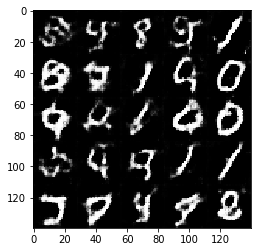

Epoch 1/2... Discriminator Loss: 0.3860... Generator Loss: 3.1695
Epoch 1/2... Discriminator Loss: 0.4015... Generator Loss: 4.2521
Epoch 1/2... Discriminator Loss: 0.3927... Generator Loss: 3.0504
Epoch 1/2... Discriminator Loss: 0.3850... Generator Loss: 2.9483
Epoch 1/2... Discriminator Loss: 0.3829... Generator Loss: 3.1291
Epoch 1/2... Discriminator Loss: 0.3931... Generator Loss: 3.2750
Epoch 1/2... Discriminator Loss: 0.3761... Generator Loss: 3.3357
Epoch 1/2... Discriminator Loss: 0.3991... Generator Loss: 2.7373
Epoch 1/2... Discriminator Loss: 0.3931... Generator Loss: 2.8911
Epoch 1/2... Discriminator Loss: 0.3850... Generator Loss: 3.5013


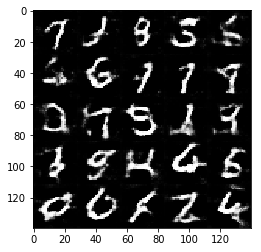

Epoch 1/2... Discriminator Loss: 0.3868... Generator Loss: 2.9028
Epoch 1/2... Discriminator Loss: 0.3848... Generator Loss: 3.2737
Epoch 1/2... Discriminator Loss: 0.3919... Generator Loss: 3.1713
Epoch 1/2... Discriminator Loss: 0.3814... Generator Loss: 3.0664
Epoch 1/2... Discriminator Loss: 0.3748... Generator Loss: 3.2101
Epoch 1/2... Discriminator Loss: 0.3858... Generator Loss: 3.2666
Epoch 1/2... Discriminator Loss: 0.3945... Generator Loss: 2.8892
Epoch 1/2... Discriminator Loss: 0.3999... Generator Loss: 2.9656
Epoch 1/2... Discriminator Loss: 0.3938... Generator Loss: 3.5488
Epoch 1/2... Discriminator Loss: 0.3873... Generator Loss: 3.2244


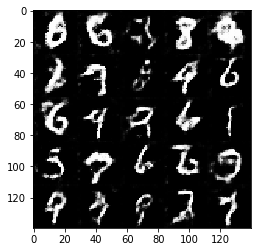

Epoch 1/2... Discriminator Loss: 0.3895... Generator Loss: 3.5734
Epoch 1/2... Discriminator Loss: 0.3921... Generator Loss: 3.6951
Epoch 1/2... Discriminator Loss: 0.3735... Generator Loss: 3.2657
Epoch 1/2... Discriminator Loss: 0.3856... Generator Loss: 3.0243
Epoch 1/2... Discriminator Loss: 0.4027... Generator Loss: 4.0572
Epoch 1/2... Discriminator Loss: 0.3857... Generator Loss: 2.9456
Epoch 1/2... Discriminator Loss: 0.3827... Generator Loss: 3.0012
Epoch 1/2... Discriminator Loss: 0.3873... Generator Loss: 3.3994
Epoch 1/2... Discriminator Loss: 0.3943... Generator Loss: 3.6420
Epoch 1/2... Discriminator Loss: 0.3950... Generator Loss: 3.7522


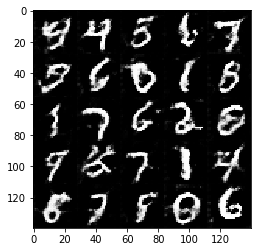

Epoch 1/2... Discriminator Loss: 0.3835... Generator Loss: 3.1843
Epoch 1/2... Discriminator Loss: 0.3903... Generator Loss: 2.8589
Epoch 1/2... Discriminator Loss: 0.3915... Generator Loss: 2.8829
Epoch 1/2... Discriminator Loss: 0.3913... Generator Loss: 3.1764
Epoch 1/2... Discriminator Loss: 0.4059... Generator Loss: 2.6352
Epoch 1/2... Discriminator Loss: 0.3838... Generator Loss: 2.9855
Epoch 1/2... Discriminator Loss: 0.3767... Generator Loss: 3.3378
Epoch 1/2... Discriminator Loss: 0.3755... Generator Loss: 3.2288
Epoch 1/2... Discriminator Loss: 0.3841... Generator Loss: 3.0635
Epoch 1/2... Discriminator Loss: 0.3953... Generator Loss: 3.5039


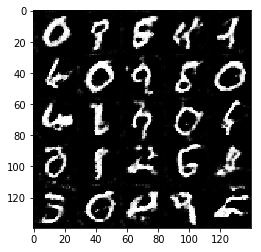

Epoch 1/2... Discriminator Loss: 0.3880... Generator Loss: 3.0696
Epoch 1/2... Discriminator Loss: 0.3926... Generator Loss: 2.8469
Epoch 1/2... Discriminator Loss: 0.4076... Generator Loss: 2.6245
Epoch 2/2... Discriminator Loss: 0.3960... Generator Loss: 2.7802
Epoch 2/2... Discriminator Loss: 0.3784... Generator Loss: 3.1806
Epoch 2/2... Discriminator Loss: 0.4402... Generator Loss: 4.4787
Epoch 2/2... Discriminator Loss: 0.3782... Generator Loss: 3.0321
Epoch 2/2... Discriminator Loss: 0.3807... Generator Loss: 3.3524
Epoch 2/2... Discriminator Loss: 0.3895... Generator Loss: 2.9279
Epoch 2/2... Discriminator Loss: 0.3786... Generator Loss: 3.0696


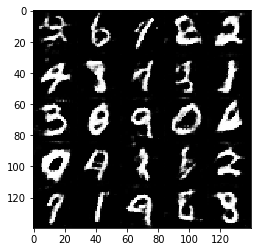

Epoch 2/2... Discriminator Loss: 0.3760... Generator Loss: 3.3743
Epoch 2/2... Discriminator Loss: 0.3914... Generator Loss: 3.4535
Epoch 2/2... Discriminator Loss: 0.3907... Generator Loss: 2.9478
Epoch 2/2... Discriminator Loss: 0.3763... Generator Loss: 3.1058
Epoch 2/2... Discriminator Loss: 0.4071... Generator Loss: 3.4035
Epoch 2/2... Discriminator Loss: 0.3839... Generator Loss: 2.9456
Epoch 2/2... Discriminator Loss: 0.3797... Generator Loss: 3.5671
Epoch 2/2... Discriminator Loss: 0.3881... Generator Loss: 2.9314
Epoch 2/2... Discriminator Loss: 0.3910... Generator Loss: 3.0533
Epoch 2/2... Discriminator Loss: 0.4014... Generator Loss: 2.6970


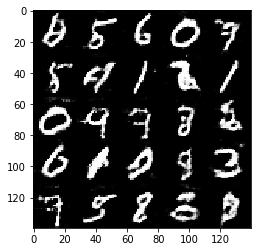

Epoch 2/2... Discriminator Loss: 0.3780... Generator Loss: 3.1403
Epoch 2/2... Discriminator Loss: 0.4007... Generator Loss: 2.7363
Epoch 2/2... Discriminator Loss: 0.4119... Generator Loss: 2.6696
Epoch 2/2... Discriminator Loss: 0.3862... Generator Loss: 3.4015
Epoch 2/2... Discriminator Loss: 0.3839... Generator Loss: 3.0828
Epoch 2/2... Discriminator Loss: 0.4058... Generator Loss: 4.2224
Epoch 2/2... Discriminator Loss: 0.4124... Generator Loss: 2.5647
Epoch 2/2... Discriminator Loss: 0.3796... Generator Loss: 3.1445
Epoch 2/2... Discriminator Loss: 0.3982... Generator Loss: 2.7620
Epoch 2/2... Discriminator Loss: 0.3772... Generator Loss: 3.1330


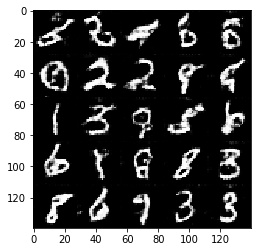

Epoch 2/2... Discriminator Loss: 0.3804... Generator Loss: 3.6289
Epoch 2/2... Discriminator Loss: 0.3890... Generator Loss: 2.8920
Epoch 2/2... Discriminator Loss: 0.3907... Generator Loss: 2.8713
Epoch 2/2... Discriminator Loss: 0.3995... Generator Loss: 3.8566
Epoch 2/2... Discriminator Loss: 0.3858... Generator Loss: 3.2080
Epoch 2/2... Discriminator Loss: 0.3826... Generator Loss: 3.3081
Epoch 2/2... Discriminator Loss: 0.3879... Generator Loss: 3.6980
Epoch 2/2... Discriminator Loss: 0.3822... Generator Loss: 3.1439
Epoch 2/2... Discriminator Loss: 0.3996... Generator Loss: 2.8950
Epoch 2/2... Discriminator Loss: 0.3810... Generator Loss: 3.0424


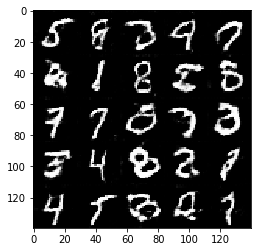

Epoch 2/2... Discriminator Loss: 0.3891... Generator Loss: 2.8589
Epoch 2/2... Discriminator Loss: 0.4419... Generator Loss: 2.3951
Epoch 2/2... Discriminator Loss: 0.3864... Generator Loss: 3.0353
Epoch 2/2... Discriminator Loss: 0.3886... Generator Loss: 2.8895
Epoch 2/2... Discriminator Loss: 0.3798... Generator Loss: 3.4506
Epoch 2/2... Discriminator Loss: 0.3969... Generator Loss: 2.7992
Epoch 2/2... Discriminator Loss: 0.3908... Generator Loss: 2.8647
Epoch 2/2... Discriminator Loss: 0.3758... Generator Loss: 3.6047
Epoch 2/2... Discriminator Loss: 0.3792... Generator Loss: 3.1253
Epoch 2/2... Discriminator Loss: 0.4079... Generator Loss: 2.6508


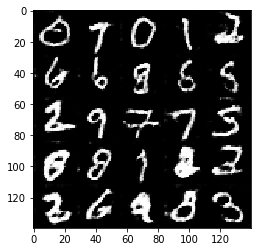

Epoch 2/2... Discriminator Loss: 0.3862... Generator Loss: 3.3106
Epoch 2/2... Discriminator Loss: 0.3763... Generator Loss: 3.1218
Epoch 2/2... Discriminator Loss: 0.4083... Generator Loss: 2.6482
Epoch 2/2... Discriminator Loss: 0.3934... Generator Loss: 2.7936
Epoch 2/2... Discriminator Loss: 0.3848... Generator Loss: 3.0705
Epoch 2/2... Discriminator Loss: 0.3820... Generator Loss: 3.5803
Epoch 2/2... Discriminator Loss: 0.3688... Generator Loss: 3.4680
Epoch 2/2... Discriminator Loss: 0.3793... Generator Loss: 3.4098
Epoch 2/2... Discriminator Loss: 0.3870... Generator Loss: 2.9226
Epoch 2/2... Discriminator Loss: 0.3825... Generator Loss: 3.1080


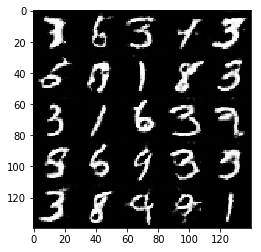

Epoch 2/2... Discriminator Loss: 0.3995... Generator Loss: 2.7474
Epoch 2/2... Discriminator Loss: 0.3928... Generator Loss: 3.0537
Epoch 2/2... Discriminator Loss: 0.3861... Generator Loss: 3.0948
Epoch 2/2... Discriminator Loss: 0.3917... Generator Loss: 2.8911
Epoch 2/2... Discriminator Loss: 0.3707... Generator Loss: 3.2104
Epoch 2/2... Discriminator Loss: 0.4171... Generator Loss: 2.6809
Epoch 2/2... Discriminator Loss: 0.3805... Generator Loss: 3.5571
Epoch 2/2... Discriminator Loss: 0.3778... Generator Loss: 3.1194
Epoch 2/2... Discriminator Loss: 0.3762... Generator Loss: 3.1904
Epoch 2/2... Discriminator Loss: 0.4020... Generator Loss: 2.6653


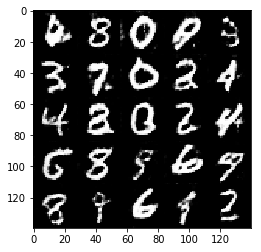

Epoch 2/2... Discriminator Loss: 0.4463... Generator Loss: 2.4062
Epoch 2/2... Discriminator Loss: 0.4114... Generator Loss: 2.6047
Epoch 2/2... Discriminator Loss: 0.3681... Generator Loss: 3.4045
Epoch 2/2... Discriminator Loss: 0.3941... Generator Loss: 2.8125
Epoch 2/2... Discriminator Loss: 0.3820... Generator Loss: 3.3166
Epoch 2/2... Discriminator Loss: 0.3815... Generator Loss: 3.5477
Epoch 2/2... Discriminator Loss: 0.4067... Generator Loss: 4.0228
Epoch 2/2... Discriminator Loss: 0.3805... Generator Loss: 3.1785
Epoch 2/2... Discriminator Loss: 0.3959... Generator Loss: 3.6970
Epoch 2/2... Discriminator Loss: 0.3814... Generator Loss: 3.0028


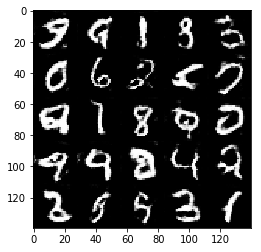

Epoch 2/2... Discriminator Loss: 0.3751... Generator Loss: 3.5291
Epoch 2/2... Discriminator Loss: 0.3856... Generator Loss: 2.9860
Epoch 2/2... Discriminator Loss: 0.3844... Generator Loss: 2.9288
Epoch 2/2... Discriminator Loss: 0.3684... Generator Loss: 3.6188
Epoch 2/2... Discriminator Loss: 0.3875... Generator Loss: 2.9786
Epoch 2/2... Discriminator Loss: 0.3841... Generator Loss: 3.1288
Epoch 2/2... Discriminator Loss: 0.3923... Generator Loss: 3.6035
Epoch 2/2... Discriminator Loss: 0.4031... Generator Loss: 2.6566
Epoch 2/2... Discriminator Loss: 0.3921... Generator Loss: 2.9337
Epoch 2/2... Discriminator Loss: 0.3759... Generator Loss: 3.3865


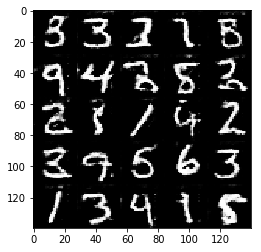

Epoch 2/2... Discriminator Loss: 0.3998... Generator Loss: 3.5309
Epoch 2/2... Discriminator Loss: 0.3964... Generator Loss: 2.7982
Epoch 2/2... Discriminator Loss: 0.3834... Generator Loss: 3.0262
Epoch 2/2... Discriminator Loss: 0.3727... Generator Loss: 3.2854
Epoch 2/2... Discriminator Loss: 0.3808... Generator Loss: 3.2507
Epoch 2/2... Discriminator Loss: 0.3940... Generator Loss: 2.9478
Epoch 2/2... Discriminator Loss: 0.3759... Generator Loss: 3.1103


In [12]:
batch_size = 64
z_dim = 128
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.4496... Generator Loss: 2.5903
Epoch 1/1... Discriminator Loss: 0.3750... Generator Loss: 3.5538
Epoch 1/1... Discriminator Loss: 0.3841... Generator Loss: 3.2325
Epoch 1/1... Discriminator Loss: 0.3560... Generator Loss: 4.9224
Epoch 1/1... Discriminator Loss: 0.3609... Generator Loss: 4.5162
Epoch 1/1... Discriminator Loss: 0.3501... Generator Loss: 4.0423
Epoch 1/1... Discriminator Loss: 0.3440... Generator Loss: 4.7900
Epoch 1/1... Discriminator Loss: 0.3510... Generator Loss: 5.5268
Epoch 1/1... Discriminator Loss: 0.3388... Generator Loss: 5.2460
Epoch 1/1... Discriminator Loss: 0.3479... Generator Loss: 3.9657


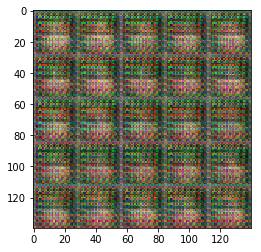

Epoch 1/1... Discriminator Loss: 0.4188... Generator Loss: 2.5375
Epoch 1/1... Discriminator Loss: 0.3696... Generator Loss: 3.3116
Epoch 1/1... Discriminator Loss: 0.3667... Generator Loss: 4.3120
Epoch 1/1... Discriminator Loss: 0.3652... Generator Loss: 3.7423
Epoch 1/1... Discriminator Loss: 0.3624... Generator Loss: 3.5341
Epoch 1/1... Discriminator Loss: 0.3755... Generator Loss: 3.3381
Epoch 1/1... Discriminator Loss: 0.3702... Generator Loss: 3.3476
Epoch 1/1... Discriminator Loss: 0.3769... Generator Loss: 3.3927
Epoch 1/1... Discriminator Loss: 0.3702... Generator Loss: 3.4499
Epoch 1/1... Discriminator Loss: 0.3655... Generator Loss: 3.4787


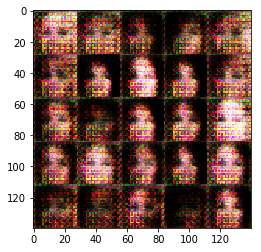

Epoch 1/1... Discriminator Loss: 0.3698... Generator Loss: 3.5107
Epoch 1/1... Discriminator Loss: 0.3752... Generator Loss: 3.8217
Epoch 1/1... Discriminator Loss: 0.3970... Generator Loss: 2.8311
Epoch 1/1... Discriminator Loss: 0.3797... Generator Loss: 3.9407
Epoch 1/1... Discriminator Loss: 0.3663... Generator Loss: 3.8996
Epoch 1/1... Discriminator Loss: 0.3713... Generator Loss: 3.3040
Epoch 1/1... Discriminator Loss: 0.3672... Generator Loss: 3.4532
Epoch 1/1... Discriminator Loss: 0.3818... Generator Loss: 3.0723
Epoch 1/1... Discriminator Loss: 0.3835... Generator Loss: 3.0802
Epoch 1/1... Discriminator Loss: 0.3802... Generator Loss: 3.1097


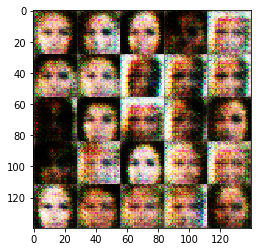

Epoch 1/1... Discriminator Loss: 0.3669... Generator Loss: 3.4684
Epoch 1/1... Discriminator Loss: 0.4184... Generator Loss: 2.5830
Epoch 1/1... Discriminator Loss: 0.3634... Generator Loss: 4.0309
Epoch 1/1... Discriminator Loss: 0.3753... Generator Loss: 3.8857
Epoch 1/1... Discriminator Loss: 0.3693... Generator Loss: 3.3921
Epoch 1/1... Discriminator Loss: 0.4146... Generator Loss: 3.2428
Epoch 1/1... Discriminator Loss: 0.3520... Generator Loss: 4.6035
Epoch 1/1... Discriminator Loss: 0.3820... Generator Loss: 3.3442
Epoch 1/1... Discriminator Loss: 0.3626... Generator Loss: 3.5215
Epoch 1/1... Discriminator Loss: 0.3885... Generator Loss: 3.2395


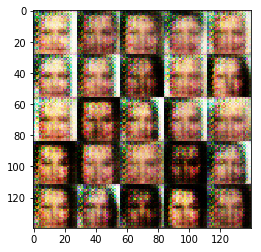

Epoch 1/1... Discriminator Loss: 0.3914... Generator Loss: 3.3357
Epoch 1/1... Discriminator Loss: 0.4093... Generator Loss: 2.7177
Epoch 1/1... Discriminator Loss: 0.3775... Generator Loss: 3.3433
Epoch 1/1... Discriminator Loss: 0.3709... Generator Loss: 3.4466
Epoch 1/1... Discriminator Loss: 0.3762... Generator Loss: 3.6779
Epoch 1/1... Discriminator Loss: 0.3918... Generator Loss: 3.2538
Epoch 1/1... Discriminator Loss: 0.3808... Generator Loss: 3.6605
Epoch 1/1... Discriminator Loss: 0.3902... Generator Loss: 3.1478
Epoch 1/1... Discriminator Loss: 0.3890... Generator Loss: 3.1405
Epoch 1/1... Discriminator Loss: 0.3827... Generator Loss: 3.2442


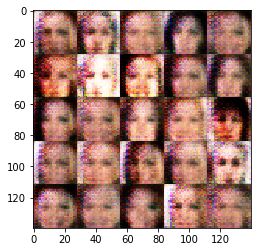

Epoch 1/1... Discriminator Loss: 0.4091... Generator Loss: 2.6775
Epoch 1/1... Discriminator Loss: 0.3855... Generator Loss: 3.3309
Epoch 1/1... Discriminator Loss: 0.3926... Generator Loss: 2.9322
Epoch 1/1... Discriminator Loss: 0.3860... Generator Loss: 3.2216
Epoch 1/1... Discriminator Loss: 0.3927... Generator Loss: 3.0095
Epoch 1/1... Discriminator Loss: 0.3862... Generator Loss: 3.0699
Epoch 1/1... Discriminator Loss: 0.3942... Generator Loss: 3.7482
Epoch 1/1... Discriminator Loss: 0.3875... Generator Loss: 3.2829
Epoch 1/1... Discriminator Loss: 0.3901... Generator Loss: 3.1077
Epoch 1/1... Discriminator Loss: 0.3842... Generator Loss: 3.3465


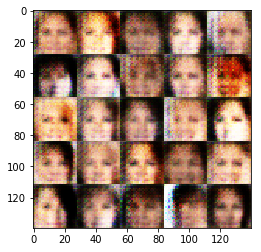

Epoch 1/1... Discriminator Loss: 0.3836... Generator Loss: 3.4208
Epoch 1/1... Discriminator Loss: 0.3889... Generator Loss: 3.0280
Epoch 1/1... Discriminator Loss: 0.3924... Generator Loss: 2.9653
Epoch 1/1... Discriminator Loss: 0.3930... Generator Loss: 2.9683
Epoch 1/1... Discriminator Loss: 0.3760... Generator Loss: 3.3862
Epoch 1/1... Discriminator Loss: 0.3813... Generator Loss: 3.4233
Epoch 1/1... Discriminator Loss: 0.3842... Generator Loss: 3.1748
Epoch 1/1... Discriminator Loss: 0.3845... Generator Loss: 3.1601
Epoch 1/1... Discriminator Loss: 0.3838... Generator Loss: 3.1343
Epoch 1/1... Discriminator Loss: 0.3907... Generator Loss: 3.0707


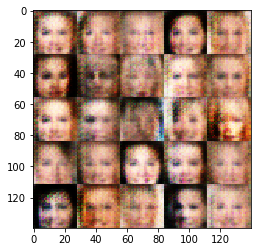

Epoch 1/1... Discriminator Loss: 0.3951... Generator Loss: 3.5616
Epoch 1/1... Discriminator Loss: 0.3900... Generator Loss: 3.6150
Epoch 1/1... Discriminator Loss: 0.3874... Generator Loss: 2.9947
Epoch 1/1... Discriminator Loss: 0.3927... Generator Loss: 3.0149
Epoch 1/1... Discriminator Loss: 0.3894... Generator Loss: 3.2826
Epoch 1/1... Discriminator Loss: 0.3902... Generator Loss: 3.0897
Epoch 1/1... Discriminator Loss: 0.3937... Generator Loss: 2.8934
Epoch 1/1... Discriminator Loss: 0.3886... Generator Loss: 3.1676
Epoch 1/1... Discriminator Loss: 0.3942... Generator Loss: 3.4867
Epoch 1/1... Discriminator Loss: 0.3771... Generator Loss: 3.3274


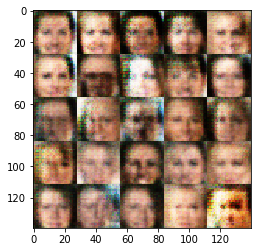

Epoch 1/1... Discriminator Loss: 0.3950... Generator Loss: 3.1205
Epoch 1/1... Discriminator Loss: 0.3944... Generator Loss: 3.1172
Epoch 1/1... Discriminator Loss: 0.3866... Generator Loss: 3.0442
Epoch 1/1... Discriminator Loss: 0.3861... Generator Loss: 3.1618
Epoch 1/1... Discriminator Loss: 0.3916... Generator Loss: 3.1094
Epoch 1/1... Discriminator Loss: 0.3847... Generator Loss: 3.0901
Epoch 1/1... Discriminator Loss: 0.3970... Generator Loss: 2.9590
Epoch 1/1... Discriminator Loss: 0.3888... Generator Loss: 3.1067
Epoch 1/1... Discriminator Loss: 0.3853... Generator Loss: 3.1970
Epoch 1/1... Discriminator Loss: 0.3863... Generator Loss: 3.2837


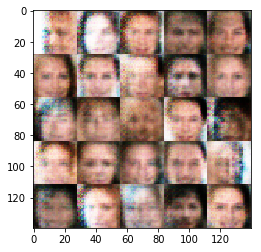

Epoch 1/1... Discriminator Loss: 0.3895... Generator Loss: 3.1597
Epoch 1/1... Discriminator Loss: 0.3935... Generator Loss: 3.0021
Epoch 1/1... Discriminator Loss: 0.3893... Generator Loss: 3.0341
Epoch 1/1... Discriminator Loss: 0.3925... Generator Loss: 3.1057
Epoch 1/1... Discriminator Loss: 0.3908... Generator Loss: 2.9512
Epoch 1/1... Discriminator Loss: 0.3867... Generator Loss: 3.1294
Epoch 1/1... Discriminator Loss: 0.3817... Generator Loss: 3.2232
Epoch 1/1... Discriminator Loss: 0.3892... Generator Loss: 3.1587
Epoch 1/1... Discriminator Loss: 0.3870... Generator Loss: 3.2039
Epoch 1/1... Discriminator Loss: 0.3850... Generator Loss: 3.0565


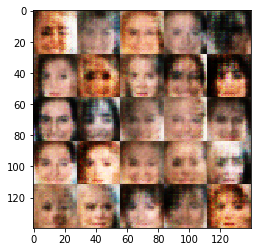

Epoch 1/1... Discriminator Loss: 0.3820... Generator Loss: 3.2451
Epoch 1/1... Discriminator Loss: 0.3854... Generator Loss: 3.0873
Epoch 1/1... Discriminator Loss: 0.3938... Generator Loss: 2.8712
Epoch 1/1... Discriminator Loss: 0.3845... Generator Loss: 3.0228
Epoch 1/1... Discriminator Loss: 0.3843... Generator Loss: 3.2140
Epoch 1/1... Discriminator Loss: 0.4108... Generator Loss: 3.8428
Epoch 1/1... Discriminator Loss: 0.3851... Generator Loss: 3.1191
Epoch 1/1... Discriminator Loss: 0.3840... Generator Loss: 3.1096
Epoch 1/1... Discriminator Loss: 0.3993... Generator Loss: 2.9092
Epoch 1/1... Discriminator Loss: 0.3935... Generator Loss: 2.8941


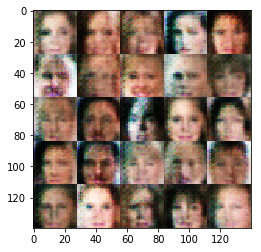

Epoch 1/1... Discriminator Loss: 0.3874... Generator Loss: 3.4502
Epoch 1/1... Discriminator Loss: 0.4001... Generator Loss: 4.0604
Epoch 1/1... Discriminator Loss: 0.3710... Generator Loss: 3.5161
Epoch 1/1... Discriminator Loss: 0.3970... Generator Loss: 2.8779
Epoch 1/1... Discriminator Loss: 0.4045... Generator Loss: 2.9592
Epoch 1/1... Discriminator Loss: 0.3958... Generator Loss: 2.9908
Epoch 1/1... Discriminator Loss: 0.3888... Generator Loss: 3.1908
Epoch 1/1... Discriminator Loss: 0.3879... Generator Loss: 3.0994
Epoch 1/1... Discriminator Loss: 0.3918... Generator Loss: 2.9496
Epoch 1/1... Discriminator Loss: 0.3965... Generator Loss: 3.0031


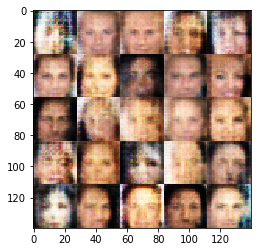

Epoch 1/1... Discriminator Loss: 0.3855... Generator Loss: 3.1529
Epoch 1/1... Discriminator Loss: 0.3877... Generator Loss: 3.1872
Epoch 1/1... Discriminator Loss: 0.3950... Generator Loss: 3.0421
Epoch 1/1... Discriminator Loss: 0.3826... Generator Loss: 3.5036
Epoch 1/1... Discriminator Loss: 0.3834... Generator Loss: 3.2103
Epoch 1/1... Discriminator Loss: 0.3924... Generator Loss: 2.8802
Epoch 1/1... Discriminator Loss: 0.3959... Generator Loss: 2.9904
Epoch 1/1... Discriminator Loss: 0.4081... Generator Loss: 2.6877
Epoch 1/1... Discriminator Loss: 0.3867... Generator Loss: 3.0660
Epoch 1/1... Discriminator Loss: 0.3875... Generator Loss: 3.0530


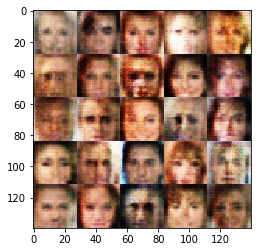

Epoch 1/1... Discriminator Loss: 0.3854... Generator Loss: 2.9763
Epoch 1/1... Discriminator Loss: 0.3860... Generator Loss: 3.1735
Epoch 1/1... Discriminator Loss: 0.3901... Generator Loss: 2.9238
Epoch 1/1... Discriminator Loss: 0.3934... Generator Loss: 3.0296
Epoch 1/1... Discriminator Loss: 0.3931... Generator Loss: 2.9261
Epoch 1/1... Discriminator Loss: 0.3911... Generator Loss: 2.9660
Epoch 1/1... Discriminator Loss: 0.3883... Generator Loss: 2.9844
Epoch 1/1... Discriminator Loss: 0.3804... Generator Loss: 3.1277
Epoch 1/1... Discriminator Loss: 0.3821... Generator Loss: 3.2519
Epoch 1/1... Discriminator Loss: 0.3833... Generator Loss: 3.3075


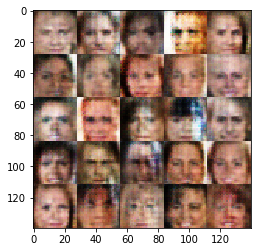

Epoch 1/1... Discriminator Loss: 0.3824... Generator Loss: 3.2492
Epoch 1/1... Discriminator Loss: 0.3821... Generator Loss: 3.4145
Epoch 1/1... Discriminator Loss: 0.3927... Generator Loss: 3.1659
Epoch 1/1... Discriminator Loss: 0.4076... Generator Loss: 2.6904
Epoch 1/1... Discriminator Loss: 0.3978... Generator Loss: 2.8991
Epoch 1/1... Discriminator Loss: 0.3842... Generator Loss: 3.1411
Epoch 1/1... Discriminator Loss: 0.3980... Generator Loss: 2.8547
Epoch 1/1... Discriminator Loss: 0.3917... Generator Loss: 2.9016
Epoch 1/1... Discriminator Loss: 0.3815... Generator Loss: 3.2585
Epoch 1/1... Discriminator Loss: 0.3832... Generator Loss: 3.0669


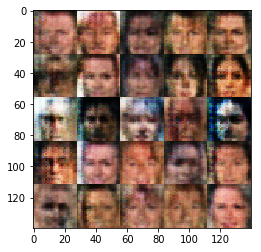

Epoch 1/1... Discriminator Loss: 0.3837... Generator Loss: 3.4377
Epoch 1/1... Discriminator Loss: 0.3874... Generator Loss: 3.2137
Epoch 1/1... Discriminator Loss: 0.3800... Generator Loss: 3.1241
Epoch 1/1... Discriminator Loss: 0.3745... Generator Loss: 3.3662
Epoch 1/1... Discriminator Loss: 0.3908... Generator Loss: 3.0999
Epoch 1/1... Discriminator Loss: 0.3857... Generator Loss: 3.0549
Epoch 1/1... Discriminator Loss: 0.3816... Generator Loss: 3.3281
Epoch 1/1... Discriminator Loss: 0.3841... Generator Loss: 3.1641
Epoch 1/1... Discriminator Loss: 0.3833... Generator Loss: 3.3119
Epoch 1/1... Discriminator Loss: 0.3895... Generator Loss: 3.0079


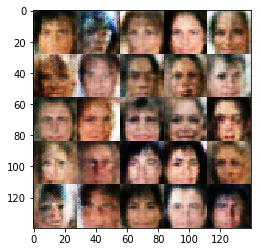

Epoch 1/1... Discriminator Loss: 0.3951... Generator Loss: 3.0298
Epoch 1/1... Discriminator Loss: 0.3855... Generator Loss: 3.6556
Epoch 1/1... Discriminator Loss: 0.3880... Generator Loss: 3.2933
Epoch 1/1... Discriminator Loss: 0.3957... Generator Loss: 2.8593
Epoch 1/1... Discriminator Loss: 0.3935... Generator Loss: 2.8356
Epoch 1/1... Discriminator Loss: 0.3903... Generator Loss: 2.9231
Epoch 1/1... Discriminator Loss: 0.3828... Generator Loss: 3.2942
Epoch 1/1... Discriminator Loss: 0.3855... Generator Loss: 3.1093
Epoch 1/1... Discriminator Loss: 0.3886... Generator Loss: 3.0388


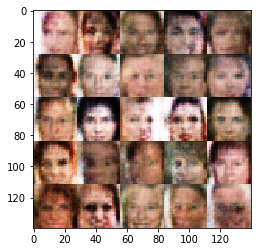

Epoch 1/1... Discriminator Loss: 0.3844... Generator Loss: 3.0069
Epoch 1/1... Discriminator Loss: 0.3934... Generator Loss: 2.8145
Epoch 1/1... Discriminator Loss: 0.3873... Generator Loss: 3.0628
Epoch 1/1... Discriminator Loss: 0.3782... Generator Loss: 3.3395
Epoch 1/1... Discriminator Loss: 0.3882... Generator Loss: 3.4461
Epoch 1/1... Discriminator Loss: 0.4028... Generator Loss: 2.9050
Epoch 1/1... Discriminator Loss: 0.3967... Generator Loss: 2.7720
Epoch 1/1... Discriminator Loss: 0.3827... Generator Loss: 3.2362
Epoch 1/1... Discriminator Loss: 0.3842... Generator Loss: 3.0251
Epoch 1/1... Discriminator Loss: 0.3844... Generator Loss: 3.0356


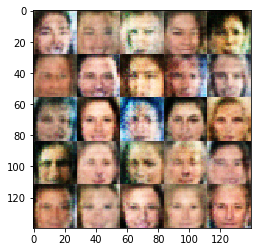

Epoch 1/1... Discriminator Loss: 0.3905... Generator Loss: 3.0792
Epoch 1/1... Discriminator Loss: 0.3818... Generator Loss: 3.3449
Epoch 1/1... Discriminator Loss: 0.3842... Generator Loss: 3.1318
Epoch 1/1... Discriminator Loss: 0.3703... Generator Loss: 3.5855
Epoch 1/1... Discriminator Loss: 0.3818... Generator Loss: 3.6226
Epoch 1/1... Discriminator Loss: 0.3826... Generator Loss: 3.0430
Epoch 1/1... Discriminator Loss: 0.3871... Generator Loss: 2.9762
Epoch 1/1... Discriminator Loss: 0.3892... Generator Loss: 2.9484
Epoch 1/1... Discriminator Loss: 0.3850... Generator Loss: 3.0282
Epoch 1/1... Discriminator Loss: 0.3826... Generator Loss: 3.1342


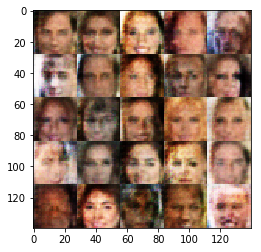

Epoch 1/1... Discriminator Loss: 0.3791... Generator Loss: 3.1755
Epoch 1/1... Discriminator Loss: 0.3922... Generator Loss: 2.9126
Epoch 1/1... Discriminator Loss: 0.3849... Generator Loss: 2.9736
Epoch 1/1... Discriminator Loss: 0.3794... Generator Loss: 3.3680
Epoch 1/1... Discriminator Loss: 0.3845... Generator Loss: 3.1835
Epoch 1/1... Discriminator Loss: 0.3869... Generator Loss: 3.2143
Epoch 1/1... Discriminator Loss: 0.3866... Generator Loss: 3.1246
Epoch 1/1... Discriminator Loss: 0.3884... Generator Loss: 2.9061
Epoch 1/1... Discriminator Loss: 0.3762... Generator Loss: 3.1954
Epoch 1/1... Discriminator Loss: 0.3919... Generator Loss: 2.8579


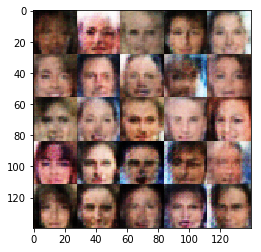

Epoch 1/1... Discriminator Loss: 0.3844... Generator Loss: 3.0570
Epoch 1/1... Discriminator Loss: 0.3869... Generator Loss: 3.0621
Epoch 1/1... Discriminator Loss: 0.3810... Generator Loss: 3.2310
Epoch 1/1... Discriminator Loss: 0.3927... Generator Loss: 2.9078
Epoch 1/1... Discriminator Loss: 0.3834... Generator Loss: 3.1693
Epoch 1/1... Discriminator Loss: 0.3935... Generator Loss: 3.0262
Epoch 1/1... Discriminator Loss: 0.3723... Generator Loss: 3.5445
Epoch 1/1... Discriminator Loss: 0.3884... Generator Loss: 3.2511
Epoch 1/1... Discriminator Loss: 0.3831... Generator Loss: 3.2267
Epoch 1/1... Discriminator Loss: 0.3941... Generator Loss: 2.8903


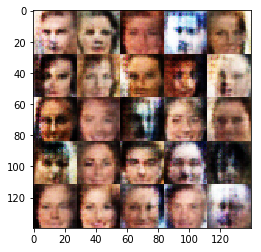

Epoch 1/1... Discriminator Loss: 0.3960... Generator Loss: 2.8971
Epoch 1/1... Discriminator Loss: 0.3785... Generator Loss: 3.2034
Epoch 1/1... Discriminator Loss: 0.3821... Generator Loss: 3.3542
Epoch 1/1... Discriminator Loss: 0.3886... Generator Loss: 3.1622
Epoch 1/1... Discriminator Loss: 0.3904... Generator Loss: 2.9591
Epoch 1/1... Discriminator Loss: 0.3845... Generator Loss: 2.9726
Epoch 1/1... Discriminator Loss: 0.3840... Generator Loss: 3.0090
Epoch 1/1... Discriminator Loss: 0.3982... Generator Loss: 3.0056
Epoch 1/1... Discriminator Loss: 0.3903... Generator Loss: 3.0332
Epoch 1/1... Discriminator Loss: 0.3909... Generator Loss: 2.8909


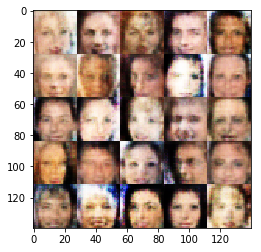

Epoch 1/1... Discriminator Loss: 0.3865... Generator Loss: 3.0104
Epoch 1/1... Discriminator Loss: 0.3887... Generator Loss: 3.0777
Epoch 1/1... Discriminator Loss: 0.3914... Generator Loss: 3.0197
Epoch 1/1... Discriminator Loss: 0.3769... Generator Loss: 3.1808
Epoch 1/1... Discriminator Loss: 0.4022... Generator Loss: 2.7556
Epoch 1/1... Discriminator Loss: 0.3814... Generator Loss: 3.0644
Epoch 1/1... Discriminator Loss: 0.4091... Generator Loss: 2.6989
Epoch 1/1... Discriminator Loss: 0.3856... Generator Loss: 2.9740
Epoch 1/1... Discriminator Loss: 0.3744... Generator Loss: 3.3689
Epoch 1/1... Discriminator Loss: 0.3873... Generator Loss: 2.9549


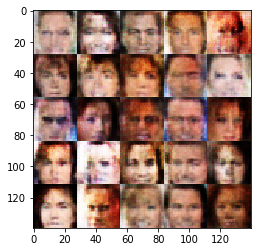

Epoch 1/1... Discriminator Loss: 0.4024... Generator Loss: 2.6982
Epoch 1/1... Discriminator Loss: 0.4090... Generator Loss: 2.6833
Epoch 1/1... Discriminator Loss: 0.3856... Generator Loss: 3.1396
Epoch 1/1... Discriminator Loss: 0.3996... Generator Loss: 2.8268
Epoch 1/1... Discriminator Loss: 0.3950... Generator Loss: 2.8810
Epoch 1/1... Discriminator Loss: 0.4024... Generator Loss: 2.7358
Epoch 1/1... Discriminator Loss: 0.3869... Generator Loss: 3.0718
Epoch 1/1... Discriminator Loss: 0.3832... Generator Loss: 3.9196
Epoch 1/1... Discriminator Loss: 0.3889... Generator Loss: 3.0175
Epoch 1/1... Discriminator Loss: 0.3840... Generator Loss: 3.0991


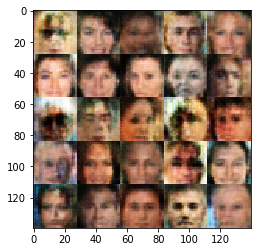

Epoch 1/1... Discriminator Loss: 0.3855... Generator Loss: 3.0939
Epoch 1/1... Discriminator Loss: 0.3885... Generator Loss: 2.9518
Epoch 1/1... Discriminator Loss: 0.3862... Generator Loss: 3.0271
Epoch 1/1... Discriminator Loss: 0.3882... Generator Loss: 3.0930
Epoch 1/1... Discriminator Loss: 0.3838... Generator Loss: 2.9600
Epoch 1/1... Discriminator Loss: 0.3816... Generator Loss: 3.1555
Epoch 1/1... Discriminator Loss: 0.3793... Generator Loss: 3.1304
Epoch 1/1... Discriminator Loss: 0.3825... Generator Loss: 3.6111
Epoch 1/1... Discriminator Loss: 0.3757... Generator Loss: 3.3370
Epoch 1/1... Discriminator Loss: 0.3821... Generator Loss: 3.2843


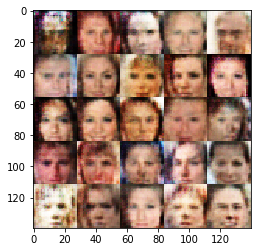

Epoch 1/1... Discriminator Loss: 0.3805... Generator Loss: 3.2249
Epoch 1/1... Discriminator Loss: 0.3882... Generator Loss: 2.9970
Epoch 1/1... Discriminator Loss: 0.3811... Generator Loss: 3.2993
Epoch 1/1... Discriminator Loss: 0.3857... Generator Loss: 3.0912
Epoch 1/1... Discriminator Loss: 0.3841... Generator Loss: 3.1383
Epoch 1/1... Discriminator Loss: 0.3813... Generator Loss: 3.0627
Epoch 1/1... Discriminator Loss: 0.3810... Generator Loss: 3.0772
Epoch 1/1... Discriminator Loss: 0.3841... Generator Loss: 3.0510
Epoch 1/1... Discriminator Loss: 0.3868... Generator Loss: 3.0376
Epoch 1/1... Discriminator Loss: 0.3755... Generator Loss: 3.2520


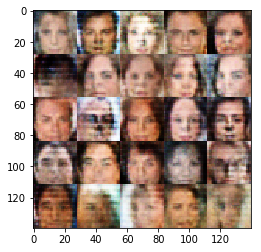

Epoch 1/1... Discriminator Loss: 0.3832... Generator Loss: 3.2201
Epoch 1/1... Discriminator Loss: 0.3789... Generator Loss: 3.2556
Epoch 1/1... Discriminator Loss: 0.4056... Generator Loss: 2.6774
Epoch 1/1... Discriminator Loss: 0.3897... Generator Loss: 2.9105
Epoch 1/1... Discriminator Loss: 0.3803... Generator Loss: 3.3179
Epoch 1/1... Discriminator Loss: 0.3760... Generator Loss: 3.1885
Epoch 1/1... Discriminator Loss: 0.3780... Generator Loss: 3.2539
Epoch 1/1... Discriminator Loss: 0.3895... Generator Loss: 2.8981
Epoch 1/1... Discriminator Loss: 0.3794... Generator Loss: 3.3027
Epoch 1/1... Discriminator Loss: 0.3783... Generator Loss: 3.3805


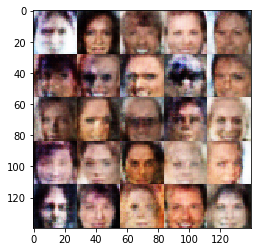

Epoch 1/1... Discriminator Loss: 0.3781... Generator Loss: 3.6240
Epoch 1/1... Discriminator Loss: 0.3861... Generator Loss: 2.9588
Epoch 1/1... Discriminator Loss: 0.3773... Generator Loss: 3.2541
Epoch 1/1... Discriminator Loss: 0.3884... Generator Loss: 3.0739
Epoch 1/1... Discriminator Loss: 0.3857... Generator Loss: 2.9459
Epoch 1/1... Discriminator Loss: 0.3818... Generator Loss: 3.1958
Epoch 1/1... Discriminator Loss: 0.3973... Generator Loss: 2.8995
Epoch 1/1... Discriminator Loss: 0.3836... Generator Loss: 3.0481
Epoch 1/1... Discriminator Loss: 0.3856... Generator Loss: 2.9326
Epoch 1/1... Discriminator Loss: 0.3819... Generator Loss: 3.0005


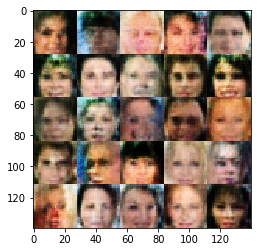

Epoch 1/1... Discriminator Loss: 0.3835... Generator Loss: 3.0633
Epoch 1/1... Discriminator Loss: 0.4024... Generator Loss: 2.6819
Epoch 1/1... Discriminator Loss: 0.3781... Generator Loss: 3.2308
Epoch 1/1... Discriminator Loss: 0.3899... Generator Loss: 2.9247
Epoch 1/1... Discriminator Loss: 0.3825... Generator Loss: 3.1033
Epoch 1/1... Discriminator Loss: 0.3861... Generator Loss: 3.0433
Epoch 1/1... Discriminator Loss: 0.3837... Generator Loss: 3.0688
Epoch 1/1... Discriminator Loss: 0.3985... Generator Loss: 2.8934
Epoch 1/1... Discriminator Loss: 0.3796... Generator Loss: 3.1764
Epoch 1/1... Discriminator Loss: 0.3871... Generator Loss: 3.0175


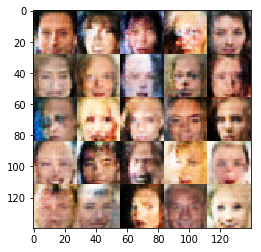

Epoch 1/1... Discriminator Loss: 0.3819... Generator Loss: 3.0916
Epoch 1/1... Discriminator Loss: 0.3853... Generator Loss: 3.0923
Epoch 1/1... Discriminator Loss: 0.3814... Generator Loss: 3.1292
Epoch 1/1... Discriminator Loss: 0.3859... Generator Loss: 3.0229
Epoch 1/1... Discriminator Loss: 0.3844... Generator Loss: 3.6834
Epoch 1/1... Discriminator Loss: 0.3846... Generator Loss: 3.0132
Epoch 1/1... Discriminator Loss: 0.3711... Generator Loss: 3.3701
Epoch 1/1... Discriminator Loss: 0.3852... Generator Loss: 3.1673
Epoch 1/1... Discriminator Loss: 0.3862... Generator Loss: 3.1241
Epoch 1/1... Discriminator Loss: 0.3778... Generator Loss: 3.2066


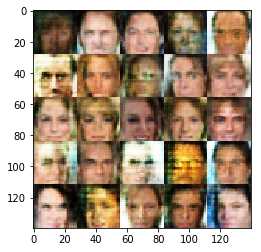

Epoch 1/1... Discriminator Loss: 0.3762... Generator Loss: 3.1884
Epoch 1/1... Discriminator Loss: 0.3900... Generator Loss: 2.8905
Epoch 1/1... Discriminator Loss: 0.3816... Generator Loss: 3.1070
Epoch 1/1... Discriminator Loss: 0.3762... Generator Loss: 3.1272
Epoch 1/1... Discriminator Loss: 0.3807... Generator Loss: 3.3005
Epoch 1/1... Discriminator Loss: 0.3861... Generator Loss: 2.9454
Epoch 1/1... Discriminator Loss: 0.3854... Generator Loss: 3.1094
Epoch 1/1... Discriminator Loss: 0.3865... Generator Loss: 2.9438
Epoch 1/1... Discriminator Loss: 0.3843... Generator Loss: 3.0155
Epoch 1/1... Discriminator Loss: 0.3879... Generator Loss: 3.1978


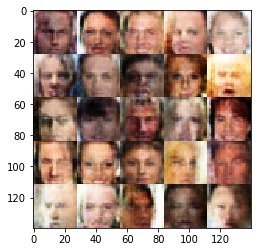

Epoch 1/1... Discriminator Loss: 0.3916... Generator Loss: 2.9315
Epoch 1/1... Discriminator Loss: 0.3855... Generator Loss: 3.9327
Epoch 1/1... Discriminator Loss: 0.3744... Generator Loss: 3.3129
Epoch 1/1... Discriminator Loss: 0.3775... Generator Loss: 3.2379
Epoch 1/1... Discriminator Loss: 0.3894... Generator Loss: 2.9193
Epoch 1/1... Discriminator Loss: 0.3784... Generator Loss: 3.0785


In [ ]:
batch_size = 64
z_dim = 128
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.